In [1]:
# ! pip install rdatasets

In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import load_wine
from rdatasets import data

In [3]:
# Load in the Datasets

# There were some issues with loading some of the datasets from the rdatasets library.
# In particular, the wine and chickwts datasets were not as feature rich as the csv files.
# I've included the csv files in the repo, for wine and chickwts.
# The USArrests dataset was loaded without issue.

# Dataset 1: Wine data (for Classification using KNN)
wine_df = pd.read_csv('wine_data.csv')

# Dataset 2: Chickwts (for Recommendation using Similarity Metrics)
chickwts_df = pd.read_csv('chickwts_data.csv')

# Dataset 3: USArrests (for Clustering using PCA, KMeans, and GMM)
us_arrests_df = data("USArrests")

# WINE

## Brief EDA

In [4]:
# Dataset Summary
# Print first 5 rows and info to get general overview
print(wine_df.head())
print(wine_df.info())

# Look for missing values
print(wine_df.isnull().sum())

# Check for duplicates
print(wine_df.duplicated().sum())

# Check for class balance
print(wine_df['target'].value_counts())

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

#### EDA Summary

All values are numeric, no missing values, and classes seem relatively balanced. No clean-up needed, and it looks like accuracy should be a meaningful metric for classification with KNN.

--------------------------------
--- Cross-Validation Results ---
--------------------------------
Best KNN Model: KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
Average Cross-Validated Accuracy: 0.9716748768472907
--------------------------------
--- Test Set Results ---
--------------------------------
k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.86      0.92        14
           2       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36

k-NN Confusion Matrix:


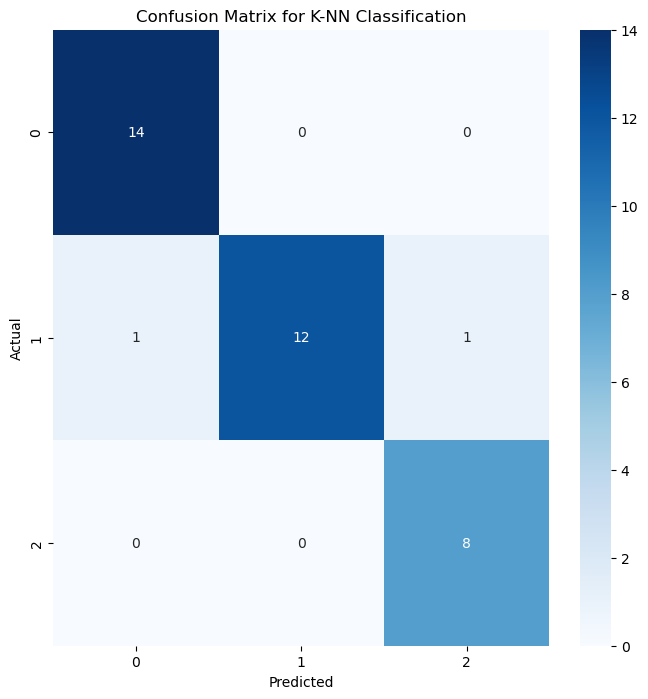

k-NN Test Accuracy: 0.94


In [5]:
# Convert target column to proper categorical format
# Even though the target is already an int, we will do this conversion to be safe
wine_df['target'] = wine_df['target'].astype('category').cat.codes

# Define features and target
X = wine_df.drop('target', axis=1)
y = wine_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Use PCA to reduce dimensionality while maintaining 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# KNN Grid Search for optimal hyperparameters
knn_params = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

knn_gs = GridSearchCV(KNeighborsClassifier(),
                     knn_params,
                     cv=5,
                     scoring='accuracy',
                     n_jobs=-1)

knn_gs.fit(X_train_pca, y_train)

# Extract the best model as measured by cross-validation accuracy
best_knn = knn_gs.best_estimator_
y_pred = best_knn.predict(X_test_pca)

# Cross-Validation Results
print("--------------------------------")
print("--- Cross-Validation Results ---")
print("--------------------------------")
print(f"Best KNN Model: {best_knn}")
print(f"Average Cross-Validated Accuracy: {knn_gs.best_score_}")
print("--------------------------------")

# Fit the best model on the training data
best_knn.fit(X_train_pca, y_train)
# Predict on the test set
y_pred = best_knn.predict(X_test_pca)

# Test Set Results
print("--- Test Set Results ---")
print("--------------------------------")
print("k-NN Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
print("k-NN Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix for K-NN Classification')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# Test Set Accuracy
print(f"k-NN Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# ChickWts

## EDA

In [6]:
print("--------------------------------")
print(chickwts_df.head())
print("--------------------------------")
print(chickwts_df.info())
print("--------------------------------")
# Look for missing values
print("Null counts:")
print(chickwts_df.isnull().sum())
print("--------------------------------")

# Check for duplicates
print("Duplicate counts:")
print(chickwts_df.duplicated().sum())
print("--------------------------------")

--------------------------------
           feed_name  proteinContent  fatContent  fiberContent  \
0          FirstPeck            19.5         3.2           2.4   
1    ChickStart Plus            18.2         3.8           3.9   
2  EarlyGrow Formula            19.3         4.6           3.2   
3  HatchMate Premier            20.2         3.7           3.8   
4        PeepNourish            19.2         3.9           4.2   

   calciumContent  phosphorusContent  moistureContent  ashContent  \
0            0.82               0.78             10.8         4.5   
1            3.02               0.68              9.3         6.9   
2            1.20               0.69             10.2         5.8   
3            3.16               0.63             11.4         5.7   
4            3.06               0.61              9.3         5.9   

   metabolizableEnergy  lysineContent  methionineContent  particleSize  \
0                 2921           0.96               0.43           3.5   
1      

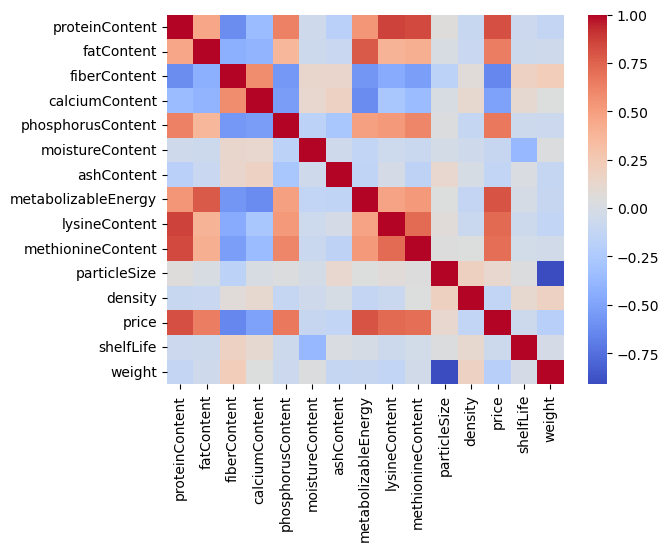

In [7]:
# Plot correlation matrix for chickwts data
chick_no_feed = chickwts_df.copy().drop(columns=['feed_name'])
sns.heatmap(chick_no_feed.corr(), annot=False, cmap='coolwarm')
plt.show()

### EDA Summary

All features outside of 'feed_name' (which is essentially the item_id) are numeric; there are no missing values; there are no duplicates; and no features seem to be so strongly correlated that they act as proxies for one another.

The data should be good to go as is, without any additional manipulation.

## NOTE FOR GRADER:

I see in the rubric that it tells us to reduce the dimension to 1 and then compute cosine similarity. I take issue with this from a mathematical perspective. With one dimensional feature vectors, cosine similarity will always be 1 or -1; this does not allow for any meaningful comparison in the context of finding similar feeds.

I suspect this was because the dataset only has two features when loaded from the rdatasets library. However, when we use the provided csv file, the dataset has many additional features that we can use for more meaningful comparison between feed types.

For the sake of completion, I've implemented the recommendations in both ways. In the cell immediately following this markdown cell (commented out currently so that only one cell will be executed when using Run All), I've reduced the dimension to 1 with PCA and then calculated reccomendations. I've also included a print statement that displays the similarity matrix and demonstrates that all cosine similarities are 1 or -1. In the cell below that, I reduce the dimensions with PCA while maintaining 95% of the variance and then calculate reccomendations - this mathematically makes more sense, and empirically seems to suggest more similar feed types.

In [8]:
# # Standardize the features
# chickwts_labels = chickwts_df['feed_name']
# chickwts_unlabeled = chickwts_df.drop(columns=['feed_name'])
# scaler = StandardScaler()
# chickwts_scaled = scaler.fit_transform(chickwts_unlabeled)

# # Perform PCA to reduce dimensionality to 1 dimension
# pca = PCA(n_components=1)

# chickwts_pca = pca.fit_transform(chickwts_scaled)

# # Compute Similarity Matrix
# sim_mat = cosine_similarity(chickwts_pca)

# # Recommendation Function
# def recommend_feeds(feed_name, num_recommendations=3):
#     # Error handling for feed_name not found in dataset
#     try:
#         feed_index = np.where(chickwts_labels == feed_name)[0][0]
#     except IndexError:
#         raise ValueError(f"Feed '{feed_name}' not found in the dataset.")

#     # Calculate similarity scores
#     similatiry_scores = list(enumerate(sim_mat[feed_index]))
#     similatiry_scores = sorted(similatiry_scores, key=lambda x: x[1], reverse=True)
#     # exclude the feed itself from the recommendations
#     similatiry_scores = similatiry_scores[1:num_recommendations+1]
    
#     # Return the recommended feeds
#     return [chickwts_df.iloc[i]['feed_name'] for i, score in similatiry_scores]

# # Example Feed Recommendation
# feed_ex_1 = 'FirstPeck'
# print(f'Recommended feeds similar to {feed_ex_1}:\n {recommend_feeds(feed_ex_1, 2)}')

# # Example Feed Recommendation
# feed_ex_2 = 'ChickStart Plus'
# print(f'Recommended feeds similar to {feed_ex_2}:\n {recommend_feeds(feed_ex_2, 5)}')

# # Example Feed Recommendation
# feed_ex_3 = 'EarlyGrow Formula'
# print(f'Recommended feeds similar to {feed_ex_3}:\n {recommend_feeds(feed_ex_3)}')

In [9]:
# Standardize the features
chickwts_labels = chickwts_df['feed_name']
chickwts_unlabeled = chickwts_df.drop(columns=['feed_name'])
scaler = StandardScaler()
chickwts_scaled = scaler.fit_transform(chickwts_unlabeled)

# Perform PCA to reduce dimensionality while maintaining 95% of variance
pca = PCA(n_components=0.95)

chickwts_pca = pca.fit_transform(chickwts_scaled)

# Compute Similarity Matrix
sim_mat = cosine_similarity(chickwts_pca)

# Recommendation Function
def recommend_feeds(feed_name, num_recommendations=3):
    # Error handling for feed_name not found in dataset
    try:
        feed_index = np.where(chickwts_labels == feed_name)[0][0]
    except IndexError:
        raise ValueError(f"Feed '{feed_name}' not found in the dataset.")

    # Calculate similarity scores
    similatiry_scores = list(enumerate(sim_mat[feed_index]))
    similatiry_scores = sorted(similatiry_scores, key=lambda x: x[1], reverse=True)
    # exclude the feed itself from the recommendations
    similatiry_scores = similatiry_scores[1:num_recommendations+1]
    
    # Return the recommended feeds
    return [chickwts_df.iloc[i]['feed_name'] for i, score in similatiry_scores]

# Example Feed Recommendation
feed_ex_1 = 'FirstPeck'
print(f'Recommended feeds similar to {feed_ex_1}:\n {recommend_feeds(feed_ex_1, 2)}')

# Example Feed Recommendation
feed_ex_2 = 'ChickStart Plus'
print(f'Recommended feeds similar to {feed_ex_2}:\n {recommend_feeds(feed_ex_2, 5)}')

# Example Feed Recommendation
feed_ex_3 = 'EarlyGrow Formula'
print(f'Recommended feeds similar to {feed_ex_3}:\n {recommend_feeds(feed_ex_3)}')

Recommended feeds similar to FirstPeck:
 ['FeatherUp Complete', 'WeightGain Pro']
Recommended feeds similar to ChickStart Plus:
 ['PeepNourish', 'ReproMax Enhanced', 'FertilityMax Formula', 'HatchMate Premier', 'PrimeFinish Complete']
Recommended feeds similar to EarlyGrow Formula:
 ['ReproNutrient Formula', 'FinishRight Premium', 'LayWell Complete']


## USArrests

### EDA

In [10]:
type(us_arrests_df)

pandas.core.frame.DataFrame

In [11]:
print("--------------------------------")
print(us_arrests_df.head())
print("--------------------------------")
print(us_arrests_df.info())
print("--------------------------------")
# Look for missing values
print("Null counts:")
print(us_arrests_df.isnull().sum())
print("--------------------------------")

# Check for duplicates
print("Duplicate counts:")
print(us_arrests_df.duplicated().sum())
print("--------------------------------")

--------------------------------
     rownames  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB
None
--------------------------------
Null counts:
rownames    0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64
--------------------------------
Duplicate counts:
0
----------------------------

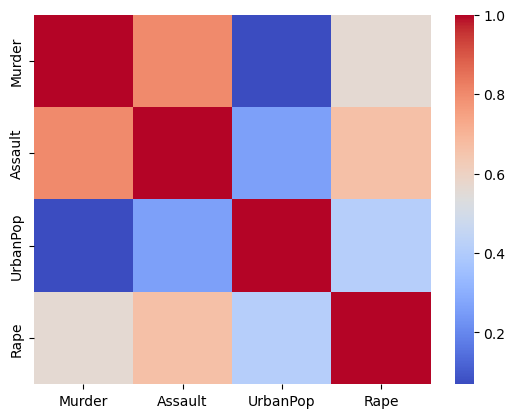

In [12]:
# Plot correlation matrix for chickwts data
usarrests_no_state = us_arrests_df.copy().drop(columns=['rownames'])
sns.heatmap(usarrests_no_state.corr(), annot=False, cmap='coolwarm')
plt.show()

### EDA Summary

All features outside of 'rownames' (the name of the state from which the data comes) are numeric; there are no missing values; there are no duplicates; and no features seem to be so strongly correlated that they act as proxies for one another. In particular, UrbanPop seems very weakly correlated with the other features, and I will opt to removie it.

No additional manipulation should be needed.

In [13]:
# Selecting top 3 relevant features, by dropping urban population
us_arrests_relevant = us_arrests_df.copy().drop(columns=['rownames', 'UrbanPop'])

# Standardize the features
scaler = StandardScaler()
us_arrests_scaled = scaler.fit_transform(us_arrests_relevant.iloc[:, 1:])

# Perform PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the data
us_arrests_pca = pca.fit_transform(us_arrests_scaled)

Text(0.5, 1.0, 'Elbow Method for K-Means')

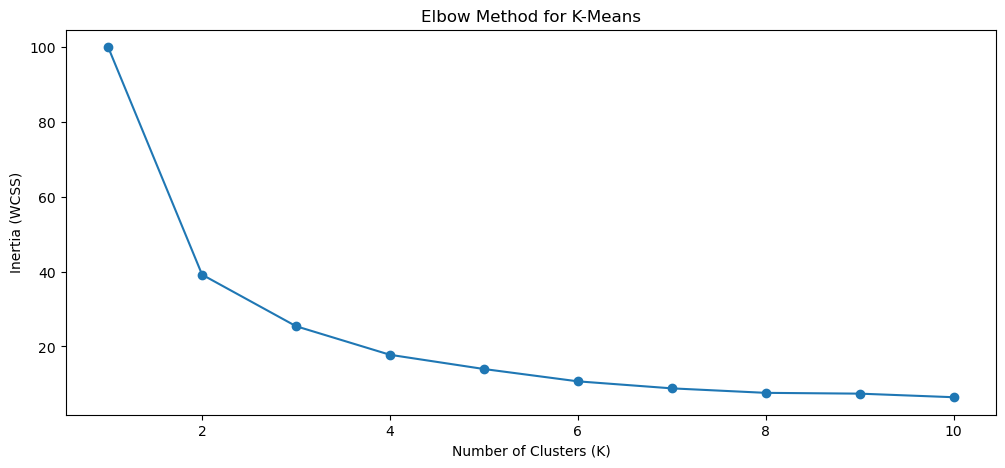

In [56]:
# Hyperparameter tuning for KMeans
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(us_arrests_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

# Elbow Method Plot
axes.plot(k_values, inertia, marker='o')
axes.set_xlabel("Number of Clusters (K)")
axes.set_ylabel("Inertia (WCSS)")
axes.set_title("Elbow Method for K-Means")

The elbow method seems to indicate that we should go with either 2 or 4 clusters. I am going to opt for 4 clusters.

In [57]:
best_k = 4
print(f'Best Number of Clusters for KNN: {best_k}')

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=best_k, random_state=42)
us_arrests_df["KMeans_Cluster"] = kmeans.fit_predict(us_arrests_pca)

Best Number of Clusters for KNN: 4


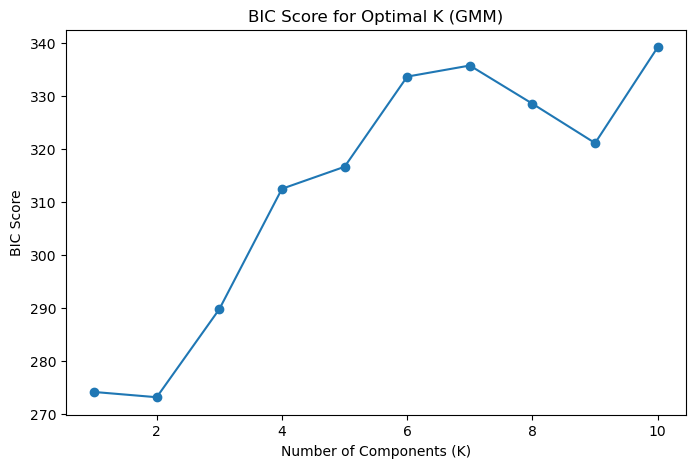

Best number of clusters for GMM: 2


In [58]:
# Hyperparameter Tuning for GMM
best_gmm_k = 1
lowest_bic = np.inf
k_values = range(1,11)
bic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(us_arrests_pca)
    bic = gmm.bic(us_arrests_pca)
    bic_scores.append(bic)
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm_k = k

# Plot BIC for GMM
plt.figure(figsize=(8,5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-')
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC Score")
plt.title("BIC Score for Optimal K (GMM)")
plt.show()


print(f'Best number of clusters for GMM: {best_gmm_k}')

# Apply GMM Clustering
gmm = GaussianMixture(n_components=best_gmm_k, random_state=42)
us_arrests_df["GMM_Cluster"] = gmm.fit_predict(us_arrests_pca)

In [59]:
# Function to draw circles around K-Means clusters
# Assumes X_pca is the PCA-transformed data to 2 dimensions
def draw_kmeans_circles(ax, kmeans, X_pca, kmeans_labels):
    for i, center in enumerate(kmeans.cluster_centers_):
        cluster_points = X_pca[kmeans_labels == i]

        #calculate distances from center to points in cluster
        distances = np.linalg.norm(cluster_points - center, axis=1)
        # extract the 90th percentile distance
        dist_pct = np.percentile(distances, 90)

        circle = patches.Circle(center, dist_pct, color='red', fill=False, 
                                linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(circle)

# Function to draw ellipses for GMM clusters
# Assumes the GMM has been fit to the PCA-transformed data in 2 dimensions
def draw_gmm_ellipses(ax, gmm, X_pca):
    for i in range(gmm.n_components):
        mean = gmm.means_[i]
        covariances = gmm.covariances_[i]

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariances)

        # Extract the angle of rotation
        largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
        angle = np.degrees(np.arctan2(largest_eigenvector[1], largest_eigenvector[0]))

        # Width and height of the ellipse (99% confidence interval)
        # Sort eigenvalues in descending order to ensure they are assigned to the correct axis
        eigenvalues = np.sort(eigenvalues)[::-1]
        width = 3 * np.sqrt(eigenvalues[0])
        height = 3 * np.sqrt(eigenvalues[1])

        # Create and add the ellipse
        ellipse = patches.Ellipse(mean, width, height, angle=angle, edgecolor='blue',
                                  facecolor='none', linewidth=2, linestyle='dashed', alpha=0.7)
        ax.add_patch(ellipse)

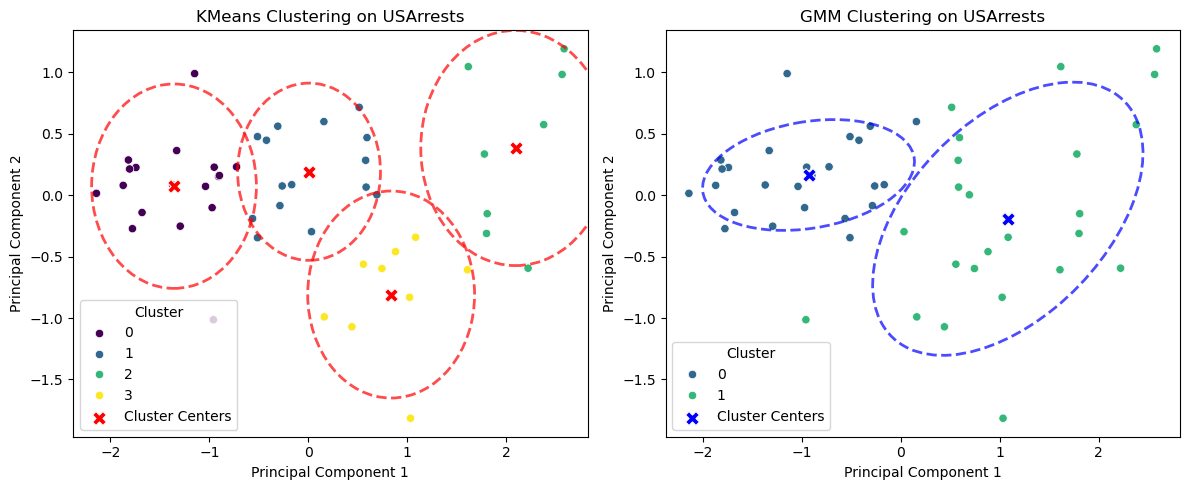

In [60]:
# Visualize KMeans and GMM Clustering
plt.figure(figsize=(12, 5))

# KMeans Clustering
plt.subplot(1, 2, 1)
sns.scatterplot(x=us_arrests_pca[:, 0], y=us_arrests_pca[:, 1],
    hue=us_arrests_df['KMeans_Cluster'], palette='viridis')
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                color='red', s=100, marker='X', label='Cluster Centers')
draw_kmeans_circles(plt.subplot(1, 2, 1), kmeans, us_arrests_pca, us_arrests_df['KMeans_Cluster'])
plt.title('KMeans Clustering on USArrests')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

# GMM Clustering
plt.subplot(1, 2, 2)
sns.scatterplot(x=us_arrests_pca[:, 0], y=us_arrests_pca[:, 1],
    hue=us_arrests_df['GMM_Cluster'], palette='viridis')
sns.scatterplot(x=gmm.means_[:, 0], y=gmm.means_[:, 1],
                color='blue', s=100, marker='X', label='Cluster Centers')
draw_gmm_ellipses(plt.subplot(1, 2, 2), gmm, us_arrests_pca)
plt.title('GMM Clustering on USArrests')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()